In [10]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import collections
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from river import ensemble
from river import compose
from river import preprocessing
from river import tree

from source.health_risk_dataset import HealthRiskDataset
from source.river_utils import evaluate_binary_model

In [12]:
# Creating a data frame
df = pd.read_csv("../datasets/Maternal-Health-Risk-Data-Set.csv")
df.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


In [13]:
df.columns

Index(['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate',
       'RiskLevel'],
      dtype='object')

In [14]:
df.dtypes

Age              int64
SystolicBP       int64
DiastolicBP      int64
BS             float64
BodyTemp       float64
HeartRate        int64
RiskLevel       object
dtype: object

In [15]:
dataset = HealthRiskDataset()

for idx, (x, y) in enumerate(dataset):
    print(x)

    if idx == 5:
        break

{'Age': 25, 'SystolicBP': 130, 'DiastolicBP': 80, 'BS': 15.0, 'BodyTemp': 98.0, 'HeartRate': 86}
{'Age': 35, 'SystolicBP': 140, 'DiastolicBP': 90, 'BS': 13.0, 'BodyTemp': 98.0, 'HeartRate': 70}
{'Age': 29, 'SystolicBP': 90, 'DiastolicBP': 70, 'BS': 8.0, 'BodyTemp': 100.0, 'HeartRate': 80}
{'Age': 30, 'SystolicBP': 140, 'DiastolicBP': 85, 'BS': 7.0, 'BodyTemp': 98.0, 'HeartRate': 70}
{'Age': 35, 'SystolicBP': 120, 'DiastolicBP': 60, 'BS': 6.1, 'BodyTemp': 98.0, 'HeartRate': 76}
{'Age': 23, 'SystolicBP': 140, 'DiastolicBP': 80, 'BS': 7.01, 'BodyTemp': 98.0, 'HeartRate': 70}


In [16]:
counts = collections.Counter(y for _, y in dataset)

for c, count in counts.items():
    print(f'{c}: {count} ({count / sum(counts.values()):.5%})')

high risk: 272 (26.82446%)
low risk: 406 (40.03945%)
mid risk: 336 (33.13609%)


### Predict with River classification models

#### Apply data transformations

In [17]:
TARGET_COLUMN = 'RiskLevel'
features = [feature for feature in df.columns if feature != TARGET_COLUMN]

transform_pipeline = compose.Select(features[0])
for feature in features[1:]:
    transform_pipeline += compose.Select(feature)
transform_pipeline |= preprocessing.MinMaxScaler()

for idx, (x, y) in enumerate(dataset):
    print(f'Initial features: {x}\n')
    x = transform_pipeline.transform_one(x)
    print(f'Transformed features: {x}\n\n')
    if idx + 1 == 10:
        break

Initial features: {'Age': 25, 'SystolicBP': 130, 'DiastolicBP': 80, 'BS': 15.0, 'BodyTemp': 98.0, 'HeartRate': 86}

Transformed features: {'HeartRate': 0.0, 'BodyTemp': 0.0, 'BS': 0.0, 'DiastolicBP': 0.0, 'SystolicBP': 0.0, 'Age': 0.0}


Initial features: {'Age': 35, 'SystolicBP': 140, 'DiastolicBP': 90, 'BS': 13.0, 'BodyTemp': 98.0, 'HeartRate': 70}

Transformed features: {'HeartRate': 0.0, 'BodyTemp': 0.0, 'BS': 0.0, 'DiastolicBP': 1.0, 'SystolicBP': 1.0, 'Age': 1.0}


Initial features: {'Age': 29, 'SystolicBP': 90, 'DiastolicBP': 70, 'BS': 8.0, 'BodyTemp': 100.0, 'HeartRate': 80}

Transformed features: {'HeartRate': 0.625, 'BodyTemp': 1.0, 'BS': 0.0, 'DiastolicBP': 0.0, 'SystolicBP': 0.0, 'Age': 0.4}


Initial features: {'Age': 30, 'SystolicBP': 140, 'DiastolicBP': 85, 'BS': 7.0, 'BodyTemp': 98.0, 'HeartRate': 70}

Transformed features: {'HeartRate': 0.0, 'BodyTemp': 0.0, 'BS': 0.0, 'DiastolicBP': 0.75, 'SystolicBP': 1.0, 'Age': 0.5}


Initial features: {'Age': 35, 'SystolicBP': 120

#### Predict with Adaptive Random Forest Classifier

Index: 50; Accuracy: 67.35%; CohenKappa: 41.49%; WeightedF1: 66.87%
Index: 100; Accuracy: 50.51%; CohenKappa: 21.56%; WeightedF1: 42.37%
Index: 150; Accuracy: 58.39%; CohenKappa: 37.81%; WeightedF1: 54.66%
Index: 200; Accuracy: 64.32%; CohenKappa: 44.26%; WeightedF1: 61.01%
Index: 250; Accuracy: 67.07%; CohenKappa: 48.21%; WeightedF1: 63.66%
Index: 300; Accuracy: 70.90%; CohenKappa: 52.50%; WeightedF1: 67.52%
Index: 350; Accuracy: 72.21%; CohenKappa: 53.57%; WeightedF1: 68.43%
Index: 400; Accuracy: 69.67%; CohenKappa: 49.91%; WeightedF1: 65.26%
Index: 450; Accuracy: 68.60%; CohenKappa: 49.04%; WeightedF1: 63.61%
Index: 500; Accuracy: 69.54%; CohenKappa: 50.20%; WeightedF1: 64.81%
Index: 550; Accuracy: 70.86%; CohenKappa: 51.73%; WeightedF1: 66.20%
Index: 600; Accuracy: 70.78%; CohenKappa: 51.54%; WeightedF1: 65.77%
Index: 650; Accuracy: 70.42%; CohenKappa: 51.22%; WeightedF1: 65.47%
Index: 700; Accuracy: 70.96%; CohenKappa: 51.91%; WeightedF1: 66.13%
Index: 750; Accuracy: 69.16%; Cohen

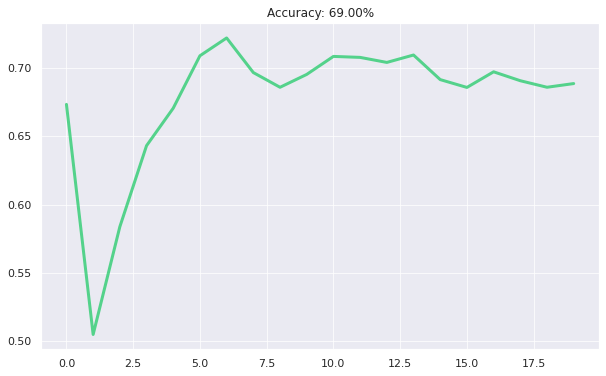

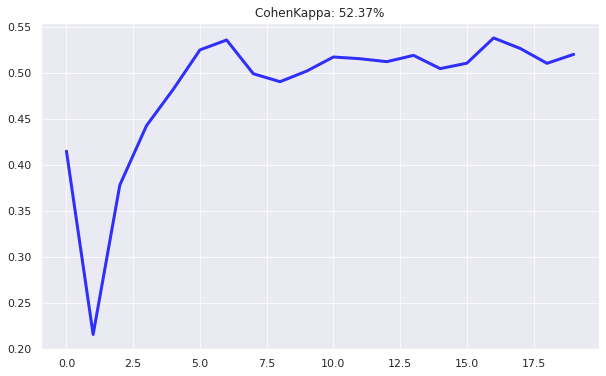

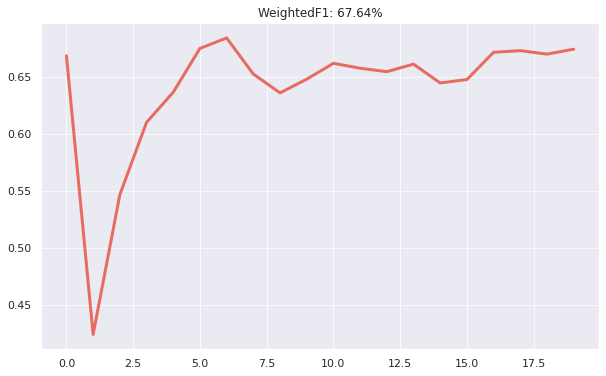

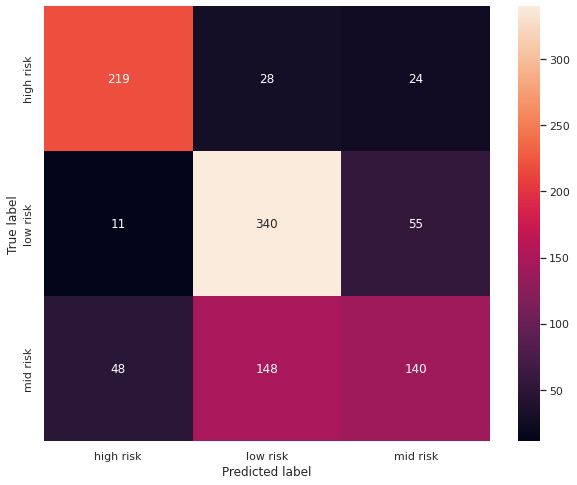

In [9]:
ARF_model = transform_pipeline | ensemble.AdaptiveRandomForestClassifier(n_models=20, seed=42, split_criterion='gini')
evaluate_binary_model(dataset, ARF_model, measure_every=50)

#### Predict with Streaming Random Patches ensemble classifier

Index: 20; Accuracy: 47.37%; CohenKappa: 15.18%; WeightedF1: 41.67%
Index: 40; Accuracy: 64.10%; CohenKappa: 40.39%; WeightedF1: 63.75%
Index: 60; Accuracy: 76.27%; CohenKappa: 49.51%; WeightedF1: 76.43%
Index: 80; Accuracy: 60.76%; CohenKappa: 28.08%; WeightedF1: 53.74%
Index: 100; Accuracy: 60.61%; CohenKappa: 35.50%; WeightedF1: 57.39%
Index: 120; Accuracy: 59.66%; CohenKappa: 38.17%; WeightedF1: 57.07%
Index: 140; Accuracy: 63.31%; CohenKappa: 45.03%; WeightedF1: 61.42%
Index: 160; Accuracy: 61.64%; CohenKappa: 42.19%; WeightedF1: 61.15%
Index: 180; Accuracy: 65.36%; CohenKappa: 47.17%; WeightedF1: 64.92%
Index: 200; Accuracy: 66.33%; CohenKappa: 48.37%; WeightedF1: 65.90%
Index: 220; Accuracy: 67.12%; CohenKappa: 49.12%; WeightedF1: 66.24%
Index: 240; Accuracy: 66.11%; CohenKappa: 47.83%; WeightedF1: 65.46%
Index: 260; Accuracy: 68.34%; CohenKappa: 50.68%; WeightedF1: 67.76%
Index: 280; Accuracy: 70.61%; CohenKappa: 53.92%; WeightedF1: 70.06%
Index: 300; Accuracy: 71.24%; CohenKap

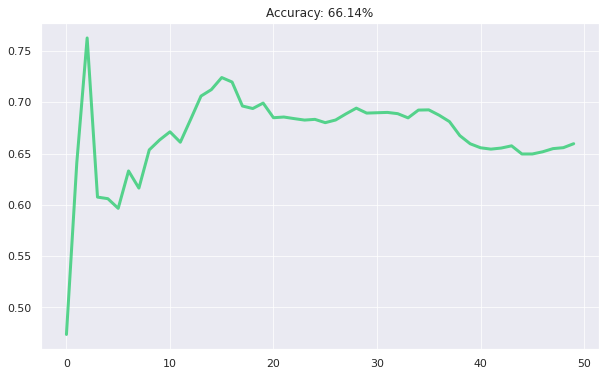

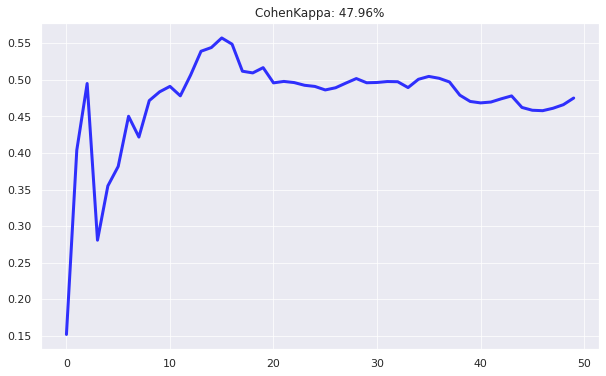

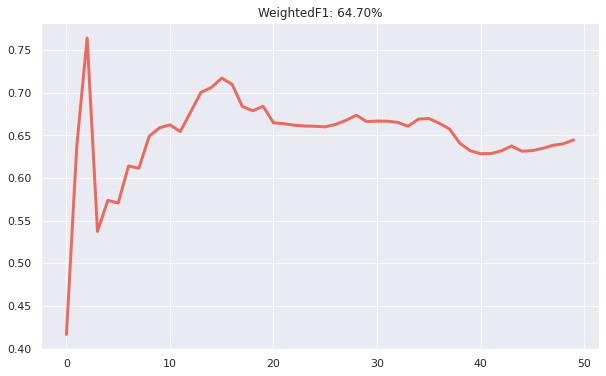

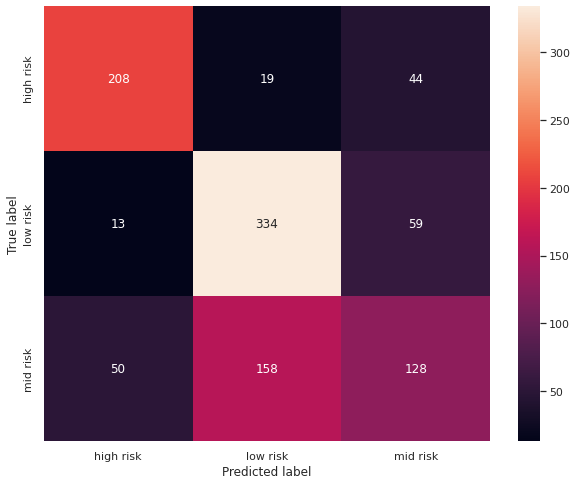

In [18]:
base_model = tree.HoeffdingTreeClassifier(
     grace_period=50, delta=0.01
)
SRP_model_obj = ensemble.SRPClassifier(
     model=base_model, n_models=3, seed=42
)
SRP_model = transform_pipeline | SRP_model_obj
evaluate_binary_model(dataset, SRP_model, measure_every=20)